In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load file
file_path = "/Users/saulpadilla/Downloads/Billing_File_022025.xlsx"
xls = pd.ExcelFile(file_path)

# Read data
billing_jan = pd.read_excel(xls, "Jan")
billing_feb = pd.read_excel(xls, "Feb")
billing_mar = pd.read_excel(xls, "March")
client_rates = pd.read_excel(xls, "Rates - Clients")
vendor_rates = pd.read_excel(xls, "Rates - Carrier")

# Combine  data
billing = pd.concat([billing_jan, billing_feb, billing_mar], ignore_index=True)

# Clean column names
billing.columns = billing.columns.str.strip().str.replace("mumber", "number")
client_rates.columns = client_rates.columns.str.strip().str.replace("mumber", "number")
vendor_rates.columns = vendor_rates.columns.str.strip().str.replace("mumber", "number")

# Convert duration from seconds to minutes
billing["Minutes_Client"] = np.ceil(billing["Duration (Seconds)"] / 60)


In [2]:
# Add vendor info from vendor rates
billing = billing.merge(
    vendor_rates[["Account ID (phone number)", "Vendor"]],
    on="Account ID (phone number)",
    how="left"
)

# Vendor billing rounding rules
def calculate_vendor_seconds(row):
    dur = row["Duration (Seconds)"]
    vendor = row["Vendor"]
    if vendor == "Vendor 1":
        return np.ceil(dur / 6) * 6
    elif vendor == "Vendor 2":
        return dur
    elif vendor == "Vendor 3":
        return np.ceil(dur / 60) * 60
    elif vendor == "Vendor 4":
        return 30 if dur <= 30 else 30 + np.ceil((dur - 30) / 6) * 6
    elif vendor == "Vendor 5":
        return np.ceil(dur / 30) * 30
    else:
        return dur

billing["Vendor_Seconds_Billed"] = billing.apply(calculate_vendor_seconds, axis=1)
billing["Vendor_Minutes_Billed"] = billing["Vendor_Seconds_Billed"] / 60


In [3]:
# Merge with vendor rates
billing = billing.merge(
    vendor_rates[
        ["Account ID (phone number)", "Vendor", "Country", "Number Type", "LandLine Rate", "Mobile Rate"]
    ],
    on=["Account ID (phone number)", "Vendor"],
    how="left",
    suffixes=("", "_Vendor")
)

# Merge with client rates
billing = billing.merge(
    client_rates[["Number Type", "LandLine Rate", "Mobile Rate"]],
    on="Number Type",
    how="left",
    suffixes=("_Vendor", "_Client")
)

# If vendor rates are much smaller, multiply by 60 to make them per-minute
median_client = billing["Mobile Rate_Client"].median(skipna=True)
median_vendor = billing["Mobile Rate_Vendor"].median(skipna=True)
if median_vendor * 60 < median_client:
    billing["LandLine Rate_Vendor"] *= 60
    billing["Mobile Rate_Vendor"] *= 60

In [4]:
#Determine rates per call 
billing["Client_Rate"] = np.where(
    billing["Called From"].str.lower().str.contains("mobile", na=False),
    billing["Mobile Rate_Client"],
    billing["LandLine Rate_Client"]
)

billing["Vendor_Rate"] = np.where(
    billing["Called From"].str.lower().str.contains("mobile", na=False),
    billing["Mobile Rate_Vendor"],
    billing["LandLine Rate_Vendor"]
)

# Billing calculations
billing["Client_Bill"] = billing["Minutes_Client"] * billing["Client_Rate"]
billing["Vendor_Cost_Total"] = billing["Minutes_Client"] * billing["Vendor_Rate"]

#Gross margin calculations 
billing["Gross_Margin"] = billing["Client_Bill"] - billing["Vendor_Cost_Total"]
billing["Gross_Margin_%"] = np.where(
    billing["Client_Bill"] > 0,
    (billing["Gross_Margin"] / billing["Client_Bill"]) * 100,
    0
)

#Remove outliers
billing_filtered = billing.loc[
    (billing["Gross_Margin_%"] > -100) & (billing["Gross_Margin_%"] < 500)
].copy()

gm_by_client = billing_filtered.groupby("Customer")[["Client_Bill", "Vendor_Cost_Total", "Gross_Margin"]].sum()
gm_by_client["Gross_Margin_%"] = gm_by_client["Gross_Margin"] / gm_by_client["Client_Bill"] * 100

gm_by_country = billing_filtered.groupby("Country")[["Client_Bill", "Vendor_Cost_Total", "Gross_Margin"]].sum()
gm_by_country["Gross_Margin_%"] = gm_by_country["Gross_Margin"] / gm_by_country["Client_Bill"] * 100

gm_by_vendor = billing_filtered.groupby("Vendor")[["Client_Bill", "Vendor_Cost_Total", "Gross_Margin"]].sum()
gm_by_vendor["Gross_Margin_%"] = gm_by_vendor["Gross_Margin"] / gm_by_vendor["Client_Bill"] * 100

gm_by_number = billing_filtered.groupby("Number Type")[["Client_Bill", "Vendor_Cost_Total", "Gross_Margin"]].sum()
gm_by_number["Gross_Margin_%"] = gm_by_number["Gross_Margin"] / gm_by_number["Client_Bill"] * 100

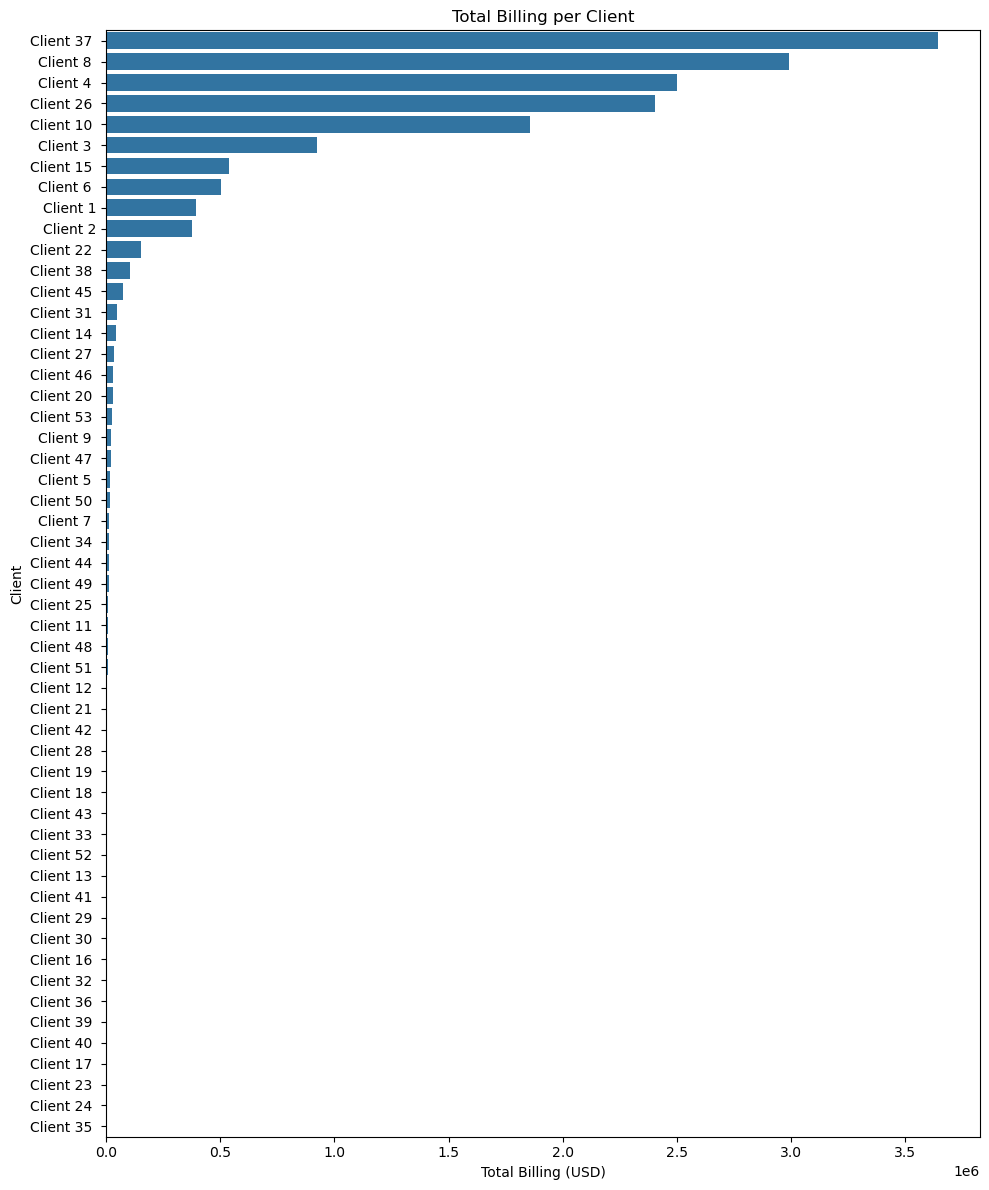

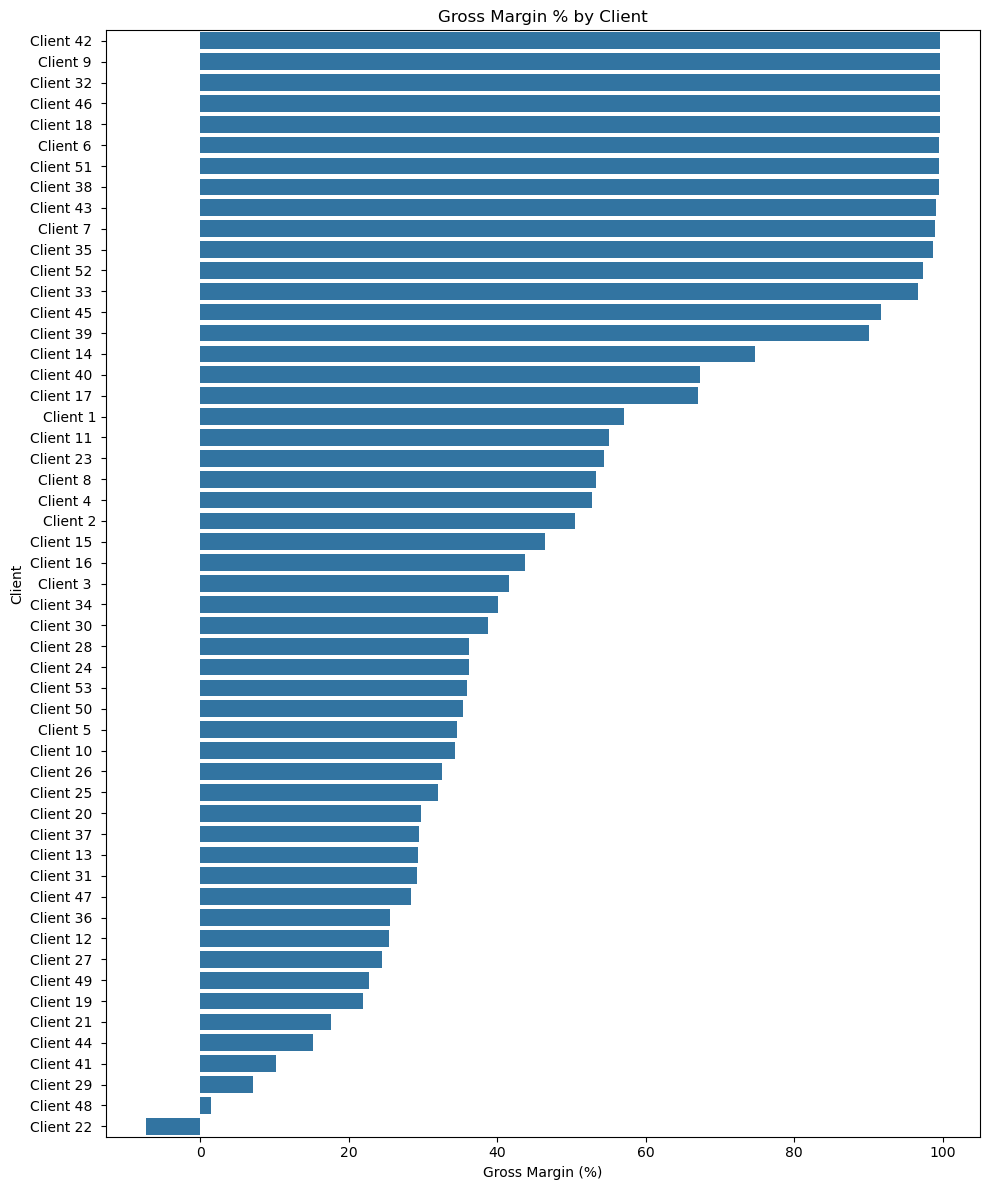

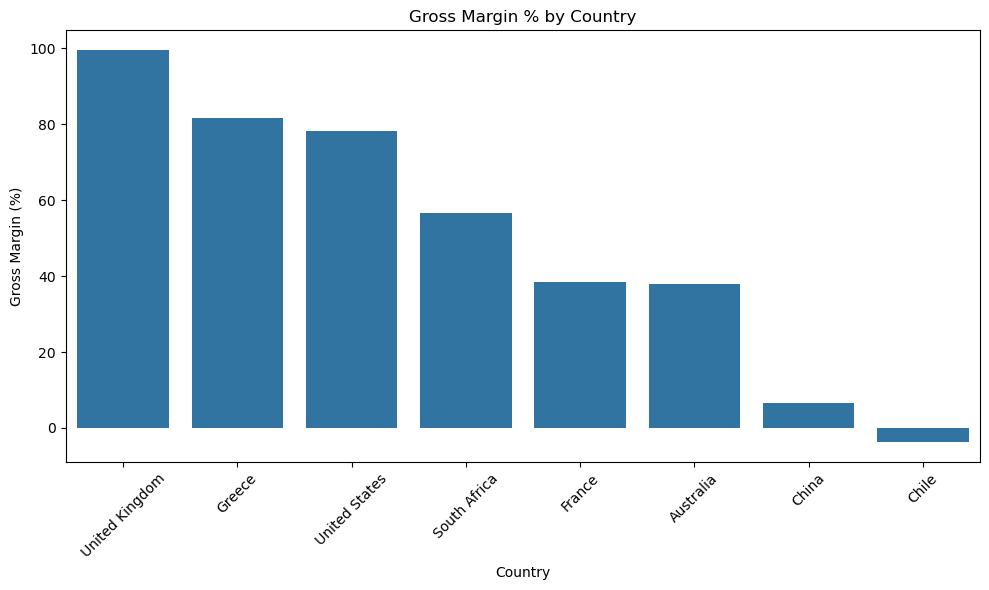

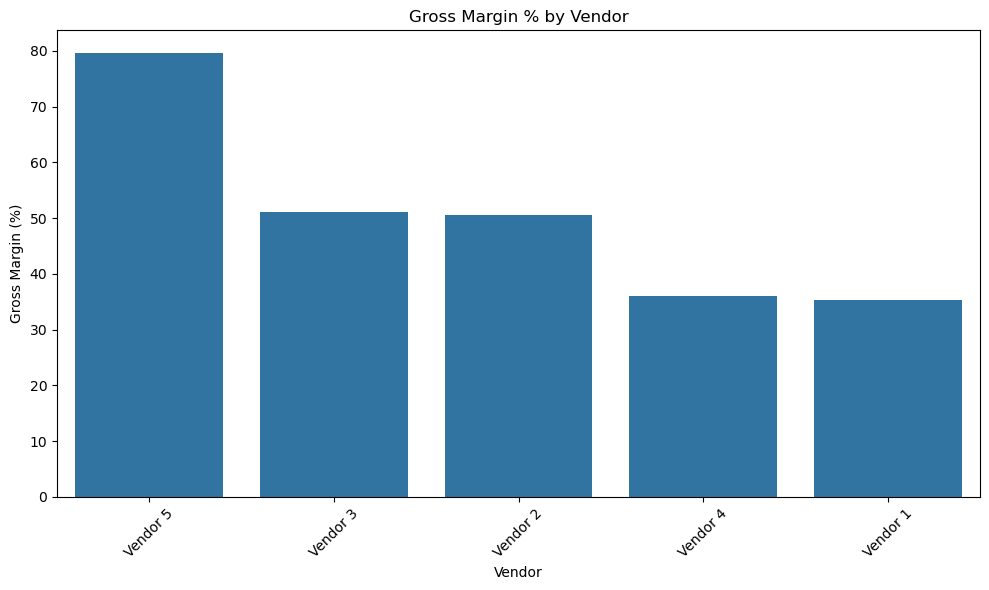

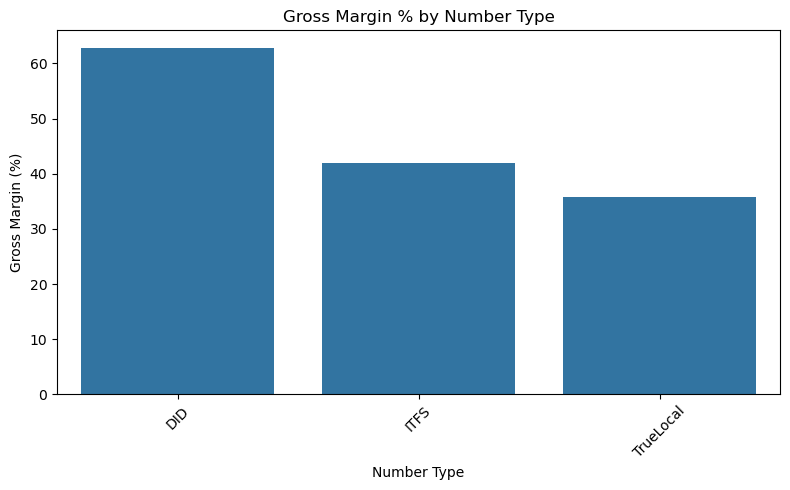

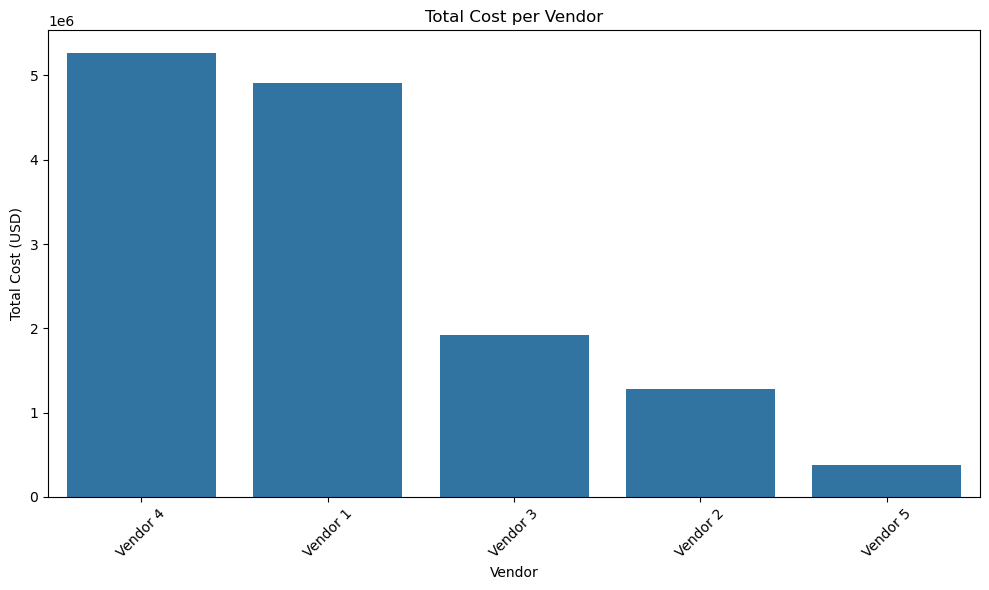

In [5]:
# Total Billing per Client
billing_per_client = billing.groupby("Customer")["Client_Bill"].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 12))
sns.barplot(y=billing_per_client.index, x=billing_per_client.values)
plt.title("Total Billing per Client")
plt.xlabel("Total Billing (USD)")
plt.ylabel("Client")
plt.tight_layout()
plt.show()

#  Gross Margin % by Client 
gm_sorted_client = gm_by_client.sort_values("Gross_Margin_%", ascending=False)
plt.figure(figsize=(10, 12))
sns.barplot(y=gm_sorted_client.index, x=gm_sorted_client["Gross_Margin_%"])
plt.title("Gross Margin % by Client")
plt.xlabel("Gross Margin (%)")
plt.ylabel("Client")
plt.tight_layout()
plt.show()

# Gross Margin % by Country
gm_sorted_country = gm_by_country.sort_values(by="Gross_Margin_%", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=gm_sorted_country.index, y=gm_sorted_country["Gross_Margin_%"])
plt.title("Gross Margin % by Country")
plt.xlabel("Country")
plt.ylabel("Gross Margin (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gross Margin % by Vendor
gm_sorted_vendor = gm_by_vendor.sort_values(by="Gross_Margin_%", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=gm_sorted_vendor.index, y=gm_sorted_vendor["Gross_Margin_%"])
plt.title("Gross Margin % by Vendor")
plt.xlabel("Vendor")
plt.ylabel("Gross Margin (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gross Margin % by Number Type 
gm_sorted_number = gm_by_number.sort_values(by="Gross_Margin_%", ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=gm_sorted_number.index, y=gm_sorted_number["Gross_Margin_%"])
plt.title("Gross Margin % by Number Type")
plt.xlabel("Number Type")
plt.ylabel("Gross Margin (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Total Cost per Vendor
cost_per_vendor = billing.groupby("Vendor")["Vendor_Cost_Total"].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=cost_per_vendor.index, y=cost_per_vendor.values)
plt.title("Total Cost per Vendor")
plt.xlabel("Vendor")
plt.ylabel("Total Cost (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Setting where is an increase of mobile rate by 7% and the landline rate by 20%

In [6]:
def simulate_rate_increase(mobile_increase=0.07, landline_increase=0.20):
    df = billing.copy()

    # Aumentar tarifas del cliente según tipo de llamada
    df["New_Client_Rate"] = np.where(
        df["Called From"].str.lower().str.contains("mobile", na=False),
        df["Client_Rate"] * (1 + mobile_increase),
        df["Client_Rate"] * (1 + landline_increase)
    )

    # Recalcular los valores de facturación con las nuevas tarifas
    df["New_Client_Bill"] = df["Minutes_Client"] * df["New_Client_Rate"]

    # Mantener el costo del proveedor igual
    df["Vendor_Cost_Total"] = df["Minutes_Client"] * df["Vendor_Rate"]

    # Recalcular margen bruto
    df["New_Gross_Margin"] = df["New_Client_Bill"] - df["Vendor_Cost_Total"]
    df["New_Gross_Margin_%"] = np.where(
        df["New_Client_Bill"] > 0,
        (df["New_Gross_Margin"] / df["New_Client_Bill"]) * 100,
        0
    )

    return df


<Figure size 1000x1000 with 0 Axes>

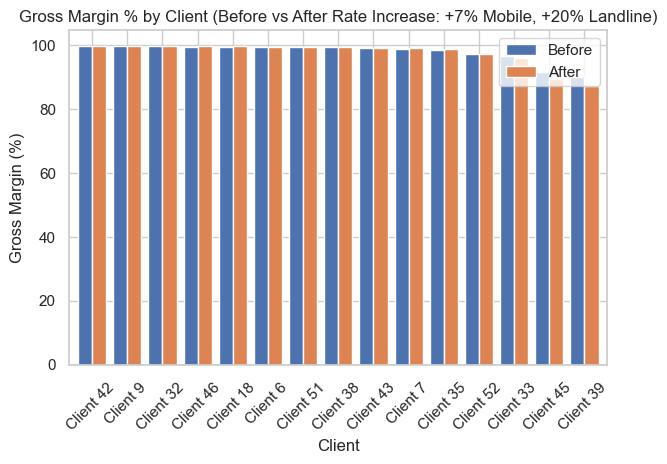

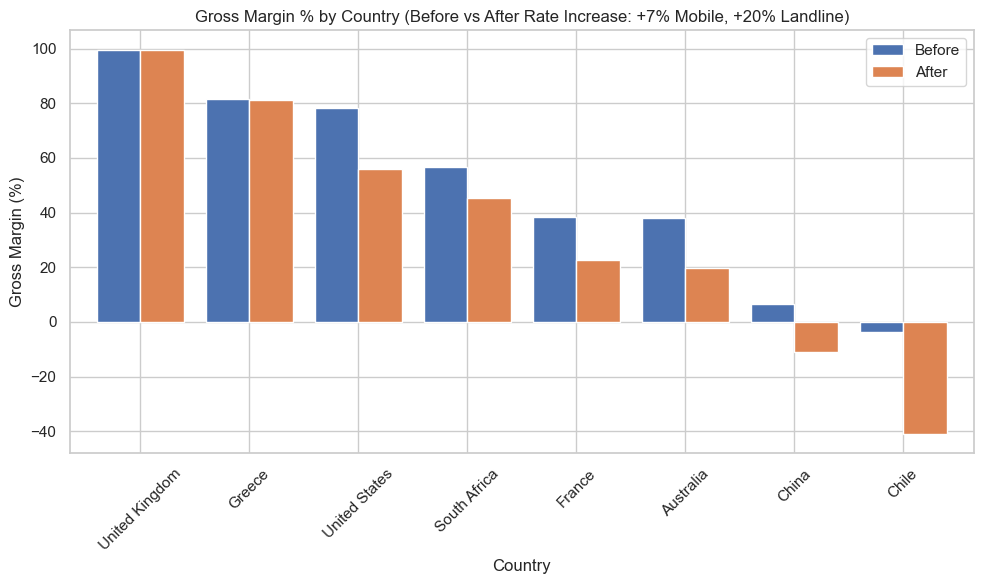

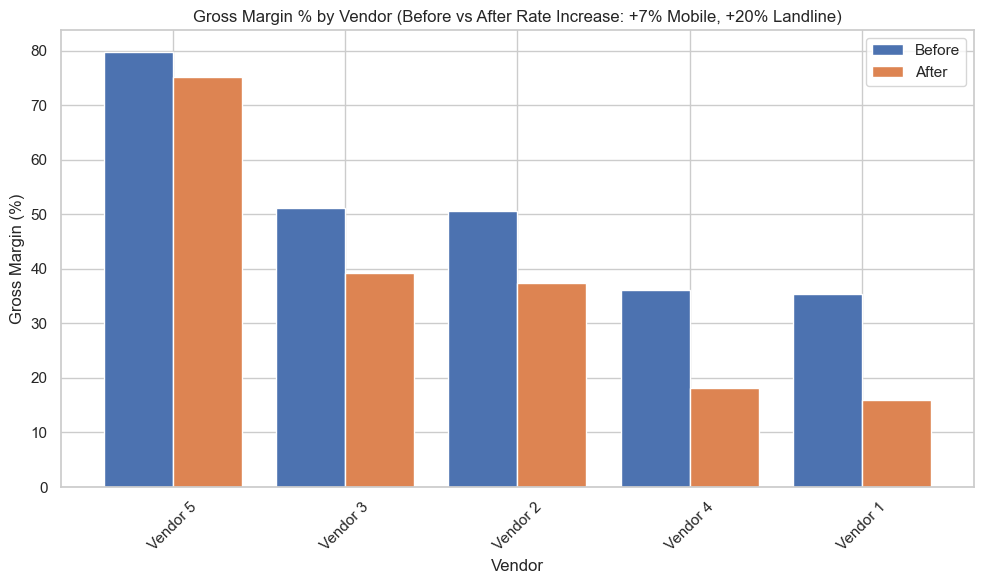

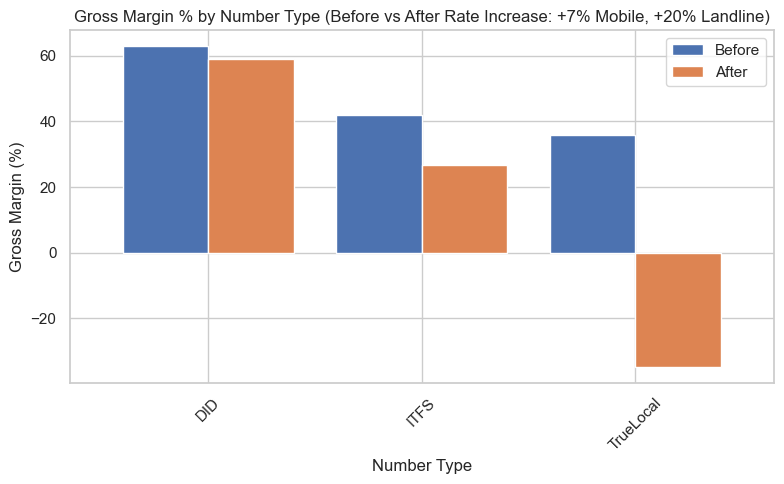

In [7]:
mobile_increase = 0.07   # +7% for mobile
landline_increase = 0.20 # +20% for landline

billing_new = simulate_rate_increase(mobile_increase, landline_increase)

# Recalculate aggregated metrics after the increase
gm_new_by_client = billing_new.groupby("Customer")[["New_Client_Bill", "Vendor_Cost_Total", "New_Gross_Margin"]].sum()
gm_new_by_client["New_Gross_Margin_%"] = gm_new_by_client["New_Gross_Margin"] / gm_new_by_client["New_Client_Bill"] * 100

gm_new_by_country = billing_new.groupby("Country")[["New_Client_Bill", "Vendor_Cost_Total", "New_Gross_Margin"]].sum()
gm_new_by_country["New_Gross_Margin_%"] = gm_new_by_country["New_Gross_Margin"] / gm_new_by_country["New_Client_Bill"] * 100

gm_new_by_vendor = billing_new.groupby("Vendor")[["New_Client_Bill", "Vendor_Cost_Total", "New_Gross_Margin"]].sum()
gm_new_by_vendor["New_Gross_Margin_%"] = gm_new_by_vendor["New_Gross_Margin"] / gm_new_by_vendor["New_Client_Bill"] * 100

gm_new_by_number = billing_new.groupby("Number Type")[["New_Client_Bill", "Vendor_Cost_Total", "New_Gross_Margin"]].sum()
gm_new_by_number["New_Gross_Margin_%"] = gm_new_by_number["New_Gross_Margin"] / gm_new_by_number["New_Client_Bill"] * 100

# Visualizations, before and after

sns.set(style="whitegrid")

# Gross Margin % by Client (Before vs After)
gm_compare_client = pd.DataFrame({
    "Before": gm_by_client["Gross_Margin_%"],
    "After": gm_new_by_client["New_Gross_Margin_%"]
}).dropna().sort_values("Before", ascending=False)

plt.figure(figsize=(10, 10))
gm_compare_client.head(15).plot(kind="bar", width=0.8)
plt.title(f"Gross Margin % by Client (Before vs After Rate Increase: +{int(mobile_increase*100)}% Mobile, +{int(landline_increase*100)}% Landline)")
plt.xlabel("Client")
plt.ylabel("Gross Margin (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gross Margin % by Country (Before vs After)
gm_compare_country = pd.DataFrame({
    "Before": gm_by_country["Gross_Margin_%"],
    "After": gm_new_by_country["New_Gross_Margin_%"]
}).dropna().sort_values("Before", ascending=False)

gm_compare_country.plot(kind="bar", figsize=(10, 6), width=0.8)
plt.title(f"Gross Margin % by Country (Before vs After Rate Increase: +{int(mobile_increase*100)}% Mobile, +{int(landline_increase*100)}% Landline)")
plt.xlabel("Country")
plt.ylabel("Gross Margin (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gross Margin % by Vendor (Before vs After)
gm_compare_vendor = pd.DataFrame({
    "Before": gm_by_vendor["Gross_Margin_%"],
    "After": gm_new_by_vendor["New_Gross_Margin_%"]
}).dropna().sort_values("Before", ascending=False)

gm_compare_vendor.plot(kind="bar", figsize=(10, 6), width=0.8)
plt.title(f"Gross Margin % by Vendor (Before vs After Rate Increase: +{int(mobile_increase*100)}% Mobile, +{int(landline_increase*100)}% Landline)")
plt.xlabel("Vendor")
plt.ylabel("Gross Margin (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gross Margin % by Number Type (Before vs After)
gm_compare_number = pd.DataFrame({
    "Before": gm_by_number["Gross_Margin_%"],
    "After": gm_new_by_number["New_Gross_Margin_%"]
}).dropna().sort_values("Before", ascending=False)

gm_compare_number.plot(kind="bar", figsize=(8, 5), width=0.8)
plt.title(f"Gross Margin % by Number Type (Before vs After Rate Increase: +{int(mobile_increase*100)}% Mobile, +{int(landline_increase*100)}% Landline)")
plt.xlabel("Number Type")
plt.ylabel("Gross Margin (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


What changes would you make to have the overall Gross Margin to be at 45%?

In [8]:
print("current Gross Margin global (%):", 
      billing["Gross_Margin"].sum() / billing["Client_Bill"].sum() * 100)

current Gross Margin global (%): 18.43551905748533


In [9]:
# Current total client bill and vendor cost
current_client_bill = billing["Client_Bill"].sum()
current_vendor_cost = billing["Vendor_Cost_Total"].sum()

# Target gross margin
target_gm = 0.45

# Calculate the required total client bill to reach target GM
target_client_bill = current_vendor_cost / (1 - target_gm)

# Required increase factor
required_increase = target_client_bill / current_client_bill - 1
print(f"Required average increase across all calls: {required_increase*100:.2f}%")

# Now calculate separate increase factors for mobile and landline based on current revenue mix
# Sum current revenue by call type
mobile_bill = billing.loc[billing["Called From"].str.lower().str.contains("mobile", na=False), "Client_Bill"].sum()
landline_bill = billing.loc[~billing["Called From"].str.lower().str.contains("mobile", na=False), "Client_Bill"].sum()

mobile_prop = mobile_bill / current_client_bill
landline_prop = landline_bill / current_client_bill

overall_factor = 1 + required_increase
mobile_increase = overall_factor - 1
landline_increase = overall_factor - 1

print(f"Required increase for Mobile calls: {mobile_increase*100:.2f}%")
print(f"Required increase for Landline calls: {landline_increase*100:.2f}%")

billing_sim = billing.copy()
billing_sim["New_Client_Rate"] = np.where(
    billing_sim["Called From"].str.lower().str.contains("mobile", na=False),
    billing_sim["Client_Rate"] * (1 + mobile_increase),
    billing_sim["Client_Rate"] * (1 + landline_increase)
)

billing_sim["New_Client_Bill"] = billing_sim["Minutes_Client"] * billing_sim["New_Client_Rate"]
billing_sim["New_Gross_Margin"] = billing_sim["New_Client_Bill"] - billing_sim["Vendor_Cost_Total"]
billing_sim["New_Gross_Margin_%"] = np.where(
    billing_sim["New_Client_Bill"] > 0,
    (billing_sim["New_Gross_Margin"] / billing_sim["New_Client_Bill"]) * 100,
    0
)

#resulting global gross margin
new_global_gm = billing_sim["New_Gross_Margin"].sum() / billing_sim["New_Client_Bill"].sum() * 100
print(f"Simulated new overall Gross Margin (%): {new_global_gm:.2f}%")


Required average increase across all calls: 48.30%
Required increase for Mobile calls: 48.30%
Required increase for Landline calls: 48.30%
Simulated new overall Gross Margin (%): 45.00%


To achieve a 45% overall Gross Margin, I calculated the required increase in client rates. I considered the contribution of mobile and landline calls separately, simulated the new billing, and confirmed that the resulting Gross Margin meets the target. This approach ensures the increase is realistic and aligned with the revenue mix.

/var/folders/rt/kfygg5s90yj4ftkjh6b4lk080000gn/T/ipykernel_8386/2619889514.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_clients["Gross_Margin_%"], y=top_clients.index, palette="Greens_r")


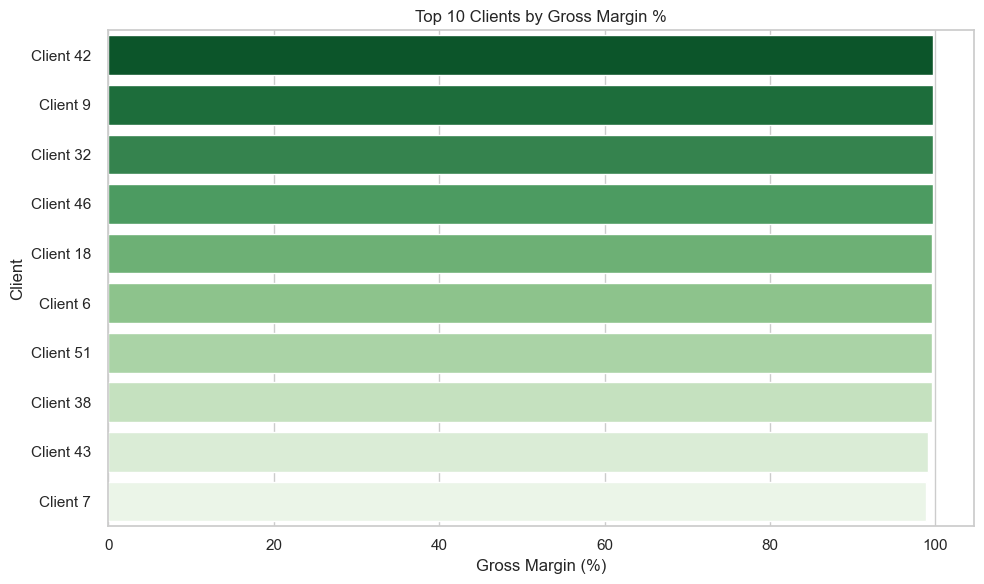

/var/folders/rt/kfygg5s90yj4ftkjh6b4lk080000gn/T/ipykernel_8386/2619889514.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_clients["Gross_Margin_%"], y=bottom_clients.index, palette="Reds_r")


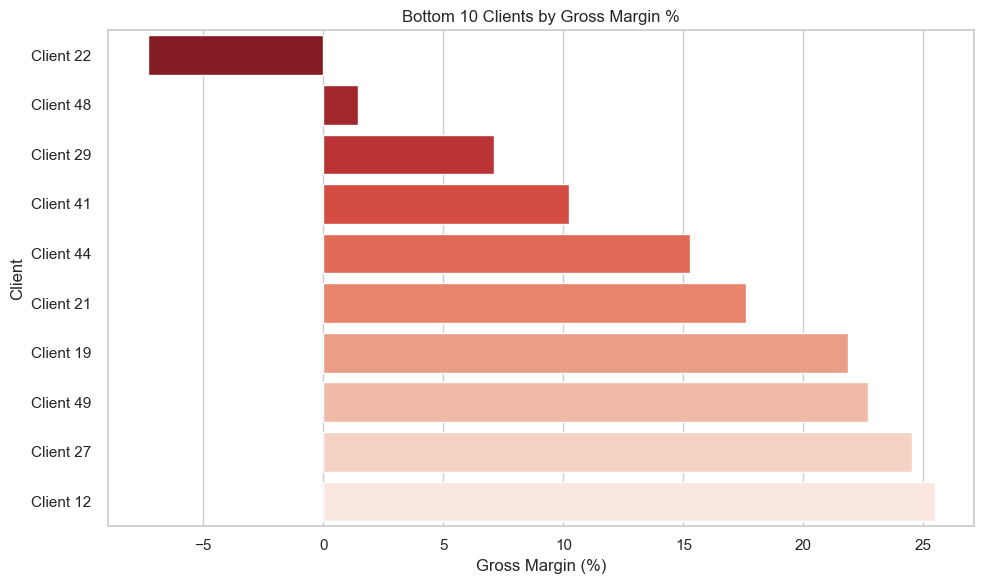

/var/folders/rt/kfygg5s90yj4ftkjh6b4lk080000gn/T/ipykernel_8386/2619889514.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cost_per_vendor_sorted.index, y=cost_per_vendor_sorted.values, palette="Blues_d")


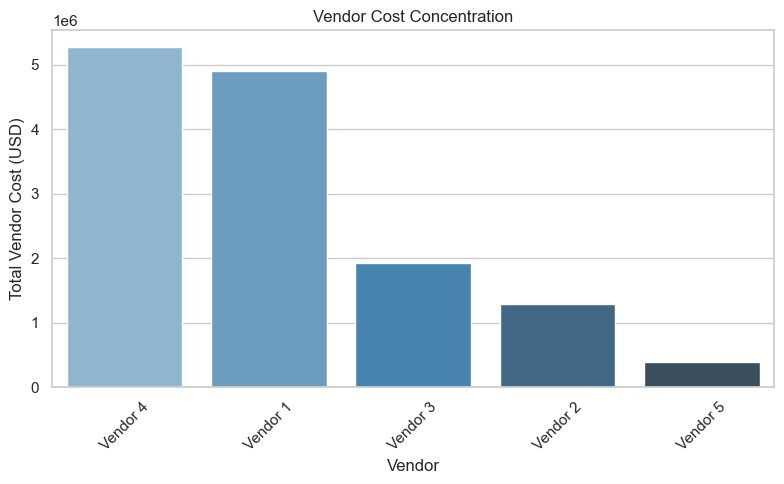

In [10]:
# Top 10 clients by GM%
top_clients = gm_by_client.sort_values("Gross_Margin_%", ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_clients["Gross_Margin_%"], y=top_clients.index, palette="Greens_r")
plt.title("Top 10 Clients by Gross Margin %")
plt.xlabel("Gross Margin (%)")
plt.ylabel("Client")
plt.tight_layout()
plt.show()

# Bottom 10 clients by GM%
bottom_clients = gm_by_client.sort_values("Gross_Margin_%", ascending=True).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=bottom_clients["Gross_Margin_%"], y=bottom_clients.index, palette="Reds_r")
plt.title("Bottom 10 Clients by Gross Margin %")
plt.xlabel("Gross Margin (%)")
plt.ylabel("Client")
plt.tight_layout()
plt.show()

# Vendor cost concentration
plt.figure(figsize=(8, 5))
cost_per_vendor_sorted = cost_per_vendor.sort_values(ascending=False)
sns.barplot(x=cost_per_vendor_sorted.index, y=cost_per_vendor_sorted.values, palette="Blues_d")
plt.title("Vendor Cost Concentration")
plt.xlabel("Vendor")
plt.ylabel("Total Vendor Cost (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The charts reveal that some clients generate very high gross margins while others are barely profitable or even negative. This indicates areas of risk where vendor costs exceed what we bill and opportunities to optimize pricing. Vendor costs are concentrated in a few suppliers which creates exposure if rates increase or service is disrupted. Overall, the data suggests that adjusting client rates for low margin segments, negotiating better terms with high cost vendors, and focusing growth on high margin clients can improve profitability and reduce financial risk.

In [ ]:
# Export
with pd.ExcelWriter("company Gross Margin Analysis.xlsx", engine="xlsxwriter") as writer:
    billing.head(1000000).to_excel(writer, sheet_name="Billing_Details", index=False)
    gm_by_client.to_excel(writer, sheet_name="GM_by_Client")
    gm_by_country.to_excel(writer, sheet_name="GM_by_Country")
    gm_by_vendor.to_excel(writer, sheet_name="GM_by_Vendor")
    gm_by_number.to_excel(writer, sheet_name="GM_by_Number_Type")

In [ ]:
import zipfile
# Export
billing.to_csv("Billing_Details.csv", index=False, encoding="utf-8-sig") #This one is really heavy, run the above, has 1 million rows
gm_by_client.to_csv("GM_by_Client.csv", index=True, encoding="utf-8-sig")
gm_by_country.to_csv("GM_by_Country.csv", index=True, encoding="utf-8-sig")
gm_by_vendor.to_csv("GM_by_Vendor.csv", index=True, encoding="utf-8-sig")
gm_by_number.to_csv("GM_by_Number_Type.csv", index=True, encoding="utf-8-sig")

with zipfile.ZipFile("Reportes_GM.zip", "w") as zipf:
    zipf.write("Billing_Details.csv")
    zipf.write("GM_by_Client.csv")
    zipf.write("GM_by_Country.csv")
    zipf.write("GM_by_Vendor.csv")
    zipf.write("GM_by_Number_Type.csv")